# Feature Extraction (Non-Food / Food Image Classification) - Case Study - Tensorflow 2.0.0
---
Author: Bhaveshkumar Thaker

---

## Install Required Libraries

In [2]:
!pip install tensorflow-gpu

     |████████████████████████████████| 380.8MB 43kB/s 
     |████████████████████████████████| 3.8MB 40.4MB/s 
     |████████████████████████████████| 450kB 43.3MB/s 
     |████████████████████████████████| 81kB 9.6MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.1 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.0 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existi

## Import Libraries

In [0]:
import os, os.path, sys, random
from zipfile import ZipFile
import shutil

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from PIL import Image

from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf

In [4]:
print(tf.version.VERSION)
print('GPU is', 'available' if tf.config.experimental.list_physical_devices('GPU') else 'NOT AVAILABLE')

2.0.0
GPU is available


In [5]:
seed = 321

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

plt.figure(figsize=(14, 11))
plt.style.use('seaborn')

colors = mcolors.TABLEAU_COLORS
sns.set(rc={
    'figure.figsize': (14, 11),
    'figure.facecolor': 'whitesmoke',
    'axes.facecolor': 'whitesmoke',
    'grid.color': 'slategrey',
    })
sns.color_palette(palette=list(colors.values()));

<Figure size 1008x792 with 0 Axes>

## Download Food-5K Dataset

This is a dataset containing 2500 food and 2500 non-food images, for the task of food/non-food classification in our paper “Food/Non-food Image Classification and Food Categorization using Pre-Trained GoogLeNet Model”. The whole dataset is divided in three parts: training, validation and evaluation. The naming convention is as follows:

`{ClassID}_{ImageID}.jpg`

*   ClassID: 0 or 1; 0 means non-food and 1 means food.
*   ImageID: ID of the image within the class.

Access:
*   URL: https://mmspg.epfl.ch/downloads/food-image-datasets/
*   protocol: FTP (we recommend to use FileZilla)
*   server: tremplin.epfl.ch
*   username: FoodImage@grebvm2.epfl.ch  (username includes @grebvm2.epfl.ch)
*   password: Cahc1moo
*   File: Food-5K.zip - The total fize size of the Food-5K dataset is about 446.9 MB.

In [0]:
INPUT_DATASET = 'Food-5K.zip'

BASE_PATH = "dataset"

TRAIN = "training"
VAL = "validation"
TEST = "evaluation"

CLASSES = ["non_food", "food"]

In [7]:
if not os.path.exists(INPUT_DATASET) :
    !wget --passive-ftp --prefer-family=ipv4 --ftp-user FoodImage@grebvm2.epfl.ch \
        --ftp-password Cahc1moo ftp://tremplin.epfl.ch/Food-5K.zip

--2019-11-11 06:09:25--  ftp://tremplin.epfl.ch/Food-5K.zip
           => ‘Food-5K.zip’
Resolving tremplin.epfl.ch (tremplin.epfl.ch)... 128.178.50.75, 2001:620:618:132:1:80b2:324b:1
Connecting to tremplin.epfl.ch (tremplin.epfl.ch)|128.178.50.75|:21... connected.
Logging in as FoodImage@grebvm2.epfl.ch ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD not needed.
==> SIZE Food-5K.zip ... 446919921
==> PASV ... done.    ==> RETR Food-5K.zip ... done.
Length: 446919921 (426M) (unauthoritative)

Food-5K.zip         100%[===================>] 426.22M   113MB/s    in 4.5s    

2019-11-11 06:09:31 (95.5 MB/s) - ‘Food-5K.zip’ saved [446919921]



## Extract Dataset Files

In [8]:
if os.path.exists(TRAIN) :
    print('Zip file is extracted already')
else :
    print('Extracting the Zip file...')
    with ZipFile(INPUT_DATASET, 'r') as zip:
        zip.extractall()
        zip.close()
        print('Zip file extracted successfully')

Extracting the Zip file...
Zip file extracted successfully


## Build Dataset

In [9]:
for split in (TRAIN, VAL, TEST):
    # grab all image paths in the current split
    print("Processing '{} split' ... ".format(split))
    for root, dirs, files in os.walk(split, topdown=True) :
        for imgfile in files:
            if imgfile.startswith('.'):
                continue;
            # extract class label from the file
            label = CLASSES[int(imgfile.split('_')[0])]
            # construct the path to the output directory
            dirPath = os.path.sep.join([BASE_PATH, split, label])
            # if the output directory does not exist, create it
            if not os.path.exists(dirPath) :
                os.makedirs(dirPath)
            # construct the path to the output image file and copy it
            pathToCopyFile = os.path.sep.join([dirPath, imgfile])
            shutil.copy2(os.path.sep.join([root, imgfile]), pathToCopyFile)

Processing 'training split' ... 
Processing 'validation split' ... 
Processing 'evaluation split' ... 


## Check Image Size

In [0]:
image_size = 224
allpaths = ['dataset/training', 'dataset/validation', 'dataset/evaluation']
category = {'non_food' : 0, 'food': 1}

In [11]:
for path in allpaths:
    for root, dirs, files in os.walk(path, topdown=True):
        for imgfile in files:
            try:
                img = Image.open(os.path.join(root, imgfile))
                img2arr = np.asarray(img, dtype=np.float32)
                #print('{}: Shape of image {} is {}'.format(os.path.basename(root), imgfile, img2arr.shape))
                print('{}: Shape of image "{}" is {}'.format(root, imgfile, img2arr.shape))
            except:
                print('Bad file: ' + os.path.join(root, imgfile))
            
            # checking dimensions of only 1 file each from folder
            break;

dataset/training/non_food: Shape of image "0_1142.jpg" is (392, 640, 3)
dataset/training/food: Shape of image "1_86.jpg" is (512, 384, 3)
dataset/validation/non_food: Shape of image "0_74.jpg" is (750, 1000, 3)
dataset/validation/food: Shape of image "1_86.jpg" is (512, 512, 3)
dataset/evaluation/non_food: Shape of image "0_74.jpg" is (768, 1024, 3)
dataset/evaluation/food: Shape of image "1_86.jpg" is (512, 384, 3)


## Data Curation

In [0]:
train_feature, val_feature, test_feature = [], [], []
train_target, val_target, test_target = [], [], []

for path in allpaths :
    num_image = 0
    for root, dir, files in os.walk(path, topdown=True) :
        for imgfile in files :
            # load the input image using the Keras helper utility
            # while ensuring the image is resized to 224x224 pixels
            img = tf.keras.preprocessing.image.load_img(os.path.join(root, imgfile), target_size=(image_size, image_size))
            img2arr = tf.keras.preprocessing.image.img_to_array(img, dtype=np.float32)
            #img2arr = img2arr / 255.0
            # preprocess the image by expanding the dimensions
            img2arr = np.expand_dims(img2arr, axis=0)
            # subtracting the mean RGB pixel intensity from the ImageNet dataset
            img2arr = tf.keras.applications.imagenet_utils.preprocess_input(img2arr)
            img.close()
            if len(img2arr.shape) == 4:
                if path.endswith(TRAIN) :
                    train_feature.append(img2arr)
                    train_target.append(category.get( os.path.basename(root) ))
                if path.endswith(VAL) :
                    val_feature.append(img2arr)
                    val_target.append(category.get( os.path.basename(root) ))
                if path.endswith(TEST) :
                    test_feature.append(img2arr)
                    test_target.append(category.get( os.path.basename(root) ))

In [0]:
train_feature = np.vstack(train_feature)
val_feature = np.vstack(val_feature)
test_feature = np.vstack(test_feature)

train_target = np.asarray(train_target, np.int)
val_target = np.asarray(val_target, np.int)
test_target = np.asarray(test_target, np.int)

In [14]:
(train_feature.shape, train_target.shape), (val_feature.shape, val_target.shape), (test_feature.shape, test_target.shape)

(((3000, 224, 224, 3), (3000,)),
 ((1000, 224, 224, 3), (1000,)),
 ((1000, 224, 224, 3), (1000,)))

## Verify Data
Displaying a sample of the labels and images from the ndarray.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


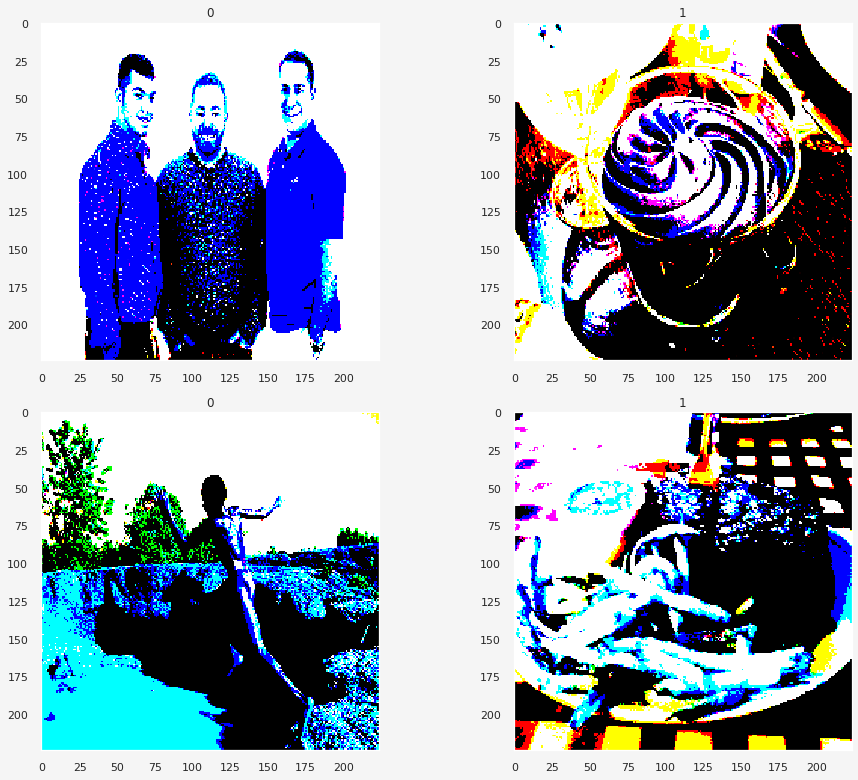

In [15]:
plt.subplot(2, 2, 1)
plt.imshow(train_feature[20], cmap = plt.cm.gray)
plt.title(train_target[20])
plt.grid(False)
plt.subplot(2, 2, 2)
plt.imshow(train_feature[2991], cmap = plt.cm.gray)
plt.title(train_target[2991])
plt.grid(False)
plt.subplot(2, 2, 3)
plt.imshow(val_feature[7], cmap = plt.cm.gray)
plt.title(val_target[7])
plt.grid(False)
plt.subplot(2, 2, 4)
plt.imshow(test_feature[623], cmap = plt.cm.gray)
plt.title(test_target[623])
plt.grid(False)

plt.tight_layout()
plt.show()

## Randomize the data

In [0]:
idx = np.random.permutation(len(train_target))

train_feature, train_target = train_feature[idx], train_target[idx]

In [0]:
#np.savez('nonfood_food-classification-train.npz', inputs=train_feature, targets=train_target)
#np.savez('nonfood_food-classification-val.npz', inputs=val_feature, targets=val_target)
#np.savez('nonfood_food-classification-test.npz', inputs=test_feature, targets=test_target)
#
#train_dataset = np.load('nonfood_food-classification-train.npz')
#validation_dataset = np.load('nonfood_food-classification-val.npz')
#test_dataset = np.load('nonfood_food-classification-test.npz')
#
#train_inputs, train_targets = train_dataset['inputs'].astype(np.float), train_dataset['targets'].astype(np.int)
#validation_inputs, validation_targets = validation_dataset['inputs'].astype(np.float), validation_dataset['targets'].astype(np.int)
#test_inputs, test_targets = test_dataset['inputs'].astype(np.float), test_dataset['targets'].astype(np.int)

## Train on Model

In [18]:
model = tf.keras.applications.VGG16(weights='imagenet', include_top=False)
features = model.predict(train_feature)

# The output dimension of the max-pooling layer is (batch_size, 7 x 7 x 512)
features.shape

58892288/58889256 [==============================] - 3s 0us/step


(3000, 7, 7, 512)

In [19]:
# reshape the features into a NumPy array of shape (batch_size, 7 * 7 * 512), treating the output of the CNN as a feature vector.
features = features.reshape(-1, 7 * 7 * 512)
#features_targets = train_targets.reshape(-1, 1)
features_targets = train_target

features.shape, features_targets.shape

((3000, 25088), (3000,))

## Write CSV File with features and class labels

In [0]:
csv = open('features-train.csv', "w")

for i in range(features.shape[0]):
    vec = ",".join([str(v) for v in features[i]])
    csv.write("{},{}\n".format(features_targets[i], vec))
csv.close()

In [21]:
with open("features-train.csv") as myfile:
    head = [next(myfile) for x in range(1)]
print(head)

['1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.684112,0.0,0.0,31.312025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.695372,0.0,0.0,26.526543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.512884,0.0,2.6441855,16.286526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.021952,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.607764,0.0,0.0,0.0,1.9889829,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.3244069,11.891093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.1963522,0.0,46.38321,0.0,0.0,0.0,0.0,0.0,0.0,3.8425918,0.0,18.199406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.783592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.1646333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.575061,0.0,0.0,0.0,0.0,0.0,19.802221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.9642141,12.931671,0.0,0.0,0.0,12.692907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.706093,0.0,0.0

## Validation and Test Features on Model

In [22]:
val_features = model.predict(val_feature)

print(val_features.shape)

val_features = val_features.reshape(-1, 7 * 7 * 512)

csv = open('features-validation.csv', "w")

for i in range(val_features.shape[0]):
    vec = ",".join([str(v) for v in val_features[i]])
    csv.write("{},{}\n".format(val_target[i], vec))
csv.close()

with open("features-validation.csv") as myfile:
    head = [next(myfile) for x in range(1)]
print(head)

(1000, 7, 7, 512)
['0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.2110221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.701862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.069895,0.0,0.0,0.0,0.0,13.946514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65.216675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.9689667,0.0,0.0,0.0,0.0,8.062776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.38093,0.0,0.0,0.0,0.0,0.0,2.5460634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.1647983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.29345,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.731955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.657673,0.0,0.0,0.0,60.134167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.374121,0.0,0.0,0.0,0.0,0.0,28.046738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.249958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.96116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [23]:
test_features = model.predict(test_feature)

print(test_features.shape)

test_features = test_features.reshape(-1, 7 * 7 * 512)

csv = open('features-test.csv', "w")

for i in range(test_features.shape[0]):
    vec = ",".join([str(v) for v in test_features[i]])
    csv.write("{},{}\n".format(test_target[i], vec))
csv.close()

with open("features-test.csv") as myfile:
    head = [next(myfile) for x in range(1)]
print(head)

(1000, 7, 7, 512)
['0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.750227,0.0,0.0,0.0,0.0,0.0,3.1261404,0.0,0.0,14.610947,0.0,31.938492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.366556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.4274125,0.0,0.0,0.0,0.0,0.36901045,0.0,0.0,0.0,0.0,0.0,4.3414807,0.0,0.0,0.0,13.948915,0.0,0.0,0.0,11.095775,0.0,0.0,0.0,3.985801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7678566,0.0,0.0,0.0,0.0,0.0,0.0,50.65532,0.0,4.631602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.835714,21.120417,38.24476,0.0,0.0,36.43869,0.0,0.0,0.0,0.0,0.0,0.0,30.341063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.535276,0.0,0.0,37.21461,0.0,23.182205,50.203682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.129354,0.0,0.0,0.0,21.18292,0.0,29.728373,0.0,0.0,5.612129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.978979,0.0,4.7767243,0.0,0.0,0.0,23.159622,0.0,0.0,0.0,0.0,25.465387,14.972971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9650